<a href="https://colab.research.google.com/github/tylee33/Paper_Research/blob/main/Forex_Stock_Price_Prediction_using_Transformer_and_Time_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ayushabrol13/Forex-Stock-Price-Prediction-using-Transformer-and-Time-Embeddings/blob/master/main.ipynb


In [2]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

physical_devices = tf.config.list_physical_devices()
print('Physical devices: {}'.format(physical_devices))

# Filter out the CPUs and keep only the GPUs
gpus = [device for device in physical_devices if 'GPU' in device.device_type]

# If GPUs are available, set memory growth to True
if len(gpus) > 0:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU memory growth: True')

Tensorflow version: 2.17.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth: True


<ipython-input-2-f89619eaf207>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Hyperparameters

In [3]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

Load IBM data

In [4]:
IBM_path = 'IBM.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace=True)
df.tail()

,Date,Open,High,Low,Close,Volume
14593,2020-01-27,132.409180,133.910141,132.026764,132.523895,4358264
14594,2020-01-28,133.365204,134.292542,132.648178,133.412994,3610374
14595,2020-01-29,133.049713,133.441681,131.548752,131.634796,3194275
14596,2020-01-30,130.745697,130.946457,129.034424,130.755264,5290563
14597,2020-01-31,136.615677,137.715103,134.598465,137.409180,19868352


In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1962-02-02,7.068196,7.112811,7.036329,7.112811,533460
1,1962-02-05,7.112811,7.112811,6.985341,7.023582,329490
2,1962-02-06,7.023582,7.036329,6.998088,7.029955,274575
3,1962-02-07,7.036329,7.074570,7.036329,7.036329,266730
4,1962-02-08,7.036329,7.074570,7.036329,7.042702,23535


In [6]:
# print the shape of the dataset
print('Shape of the dataframe: {}'.format(df.shape))

Shape of the dataframe: (14598, 6)


Plot daily IBM closing prices and volume

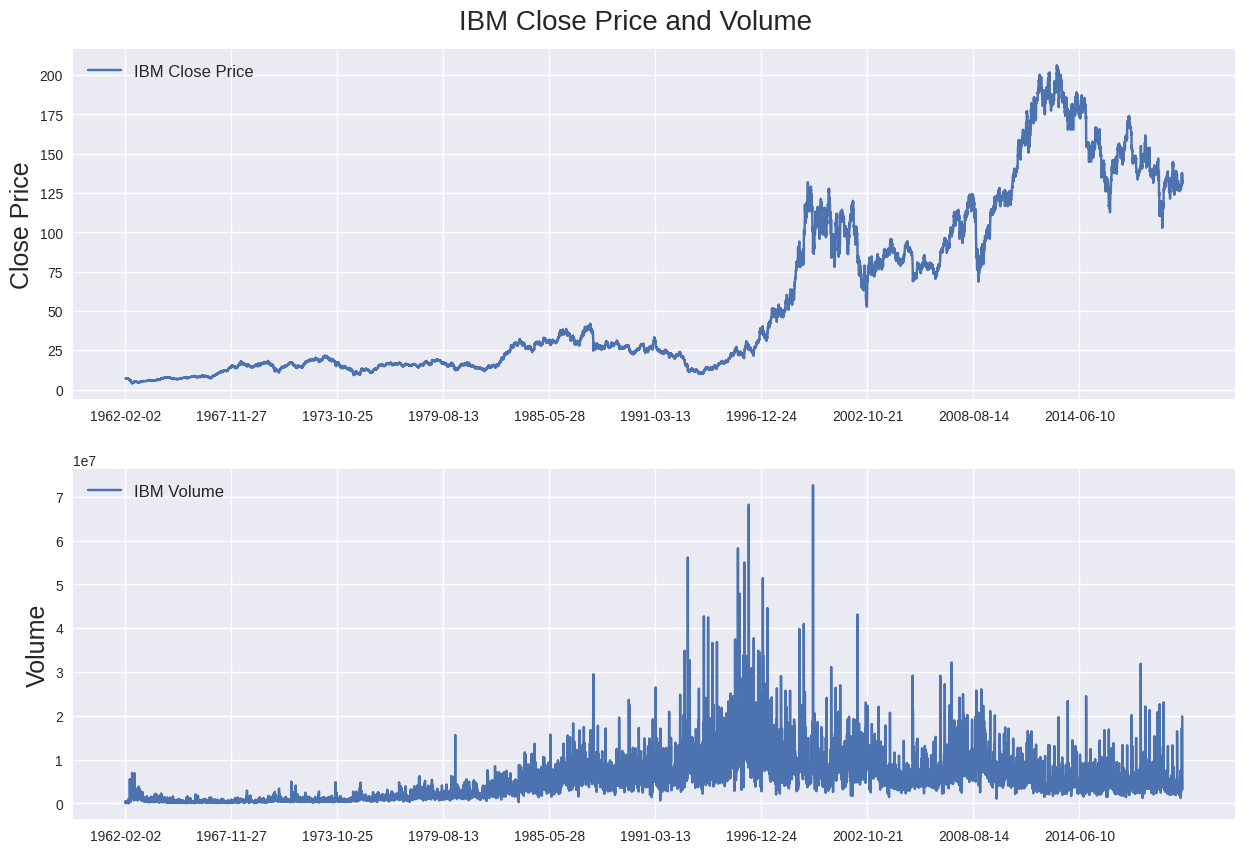

In [7]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

Calculate normalized percentage change of all columns

In [8]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11678, 5)
Validation data shape: (1460, 5)
Test data shape: (1459, 5)


,Open,High,Low,Close,Volume
1,0.607647,0.592227,0.574525,0.561581,0.023755
2,0.561581,0.565959,0.596685,0.594444,0.032809
3,0.596661,0.605504,0.605577,0.594442,0.038605
4,0.592227,0.592227,0.592227,0.594440,0.001533
5,0.594440,0.598830,0.583376,0.609914,0.809360


Plot daily changes of close prices and volume

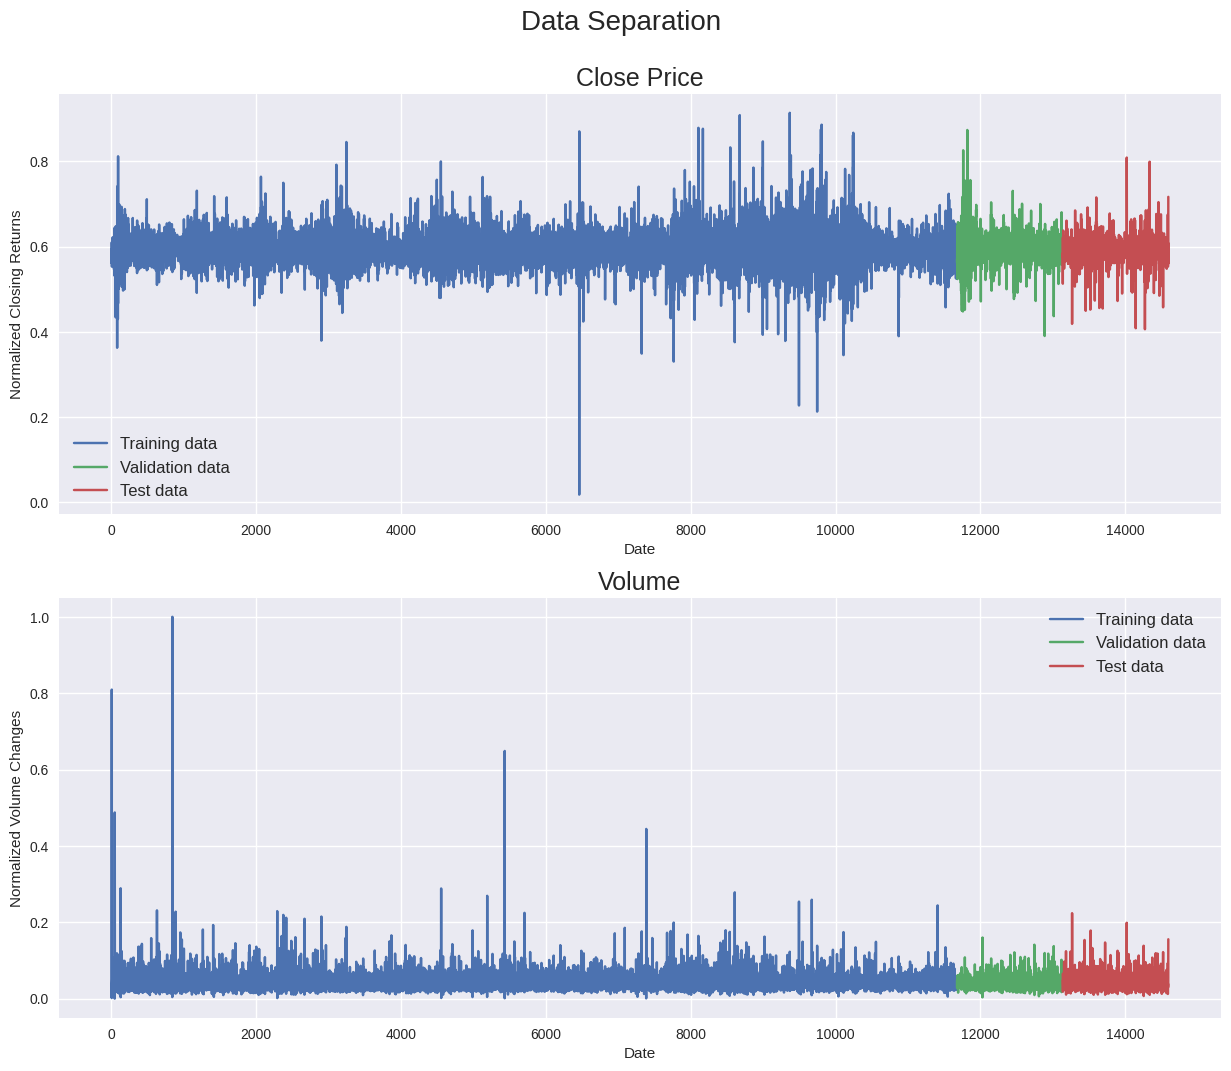

In [9]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

Create chunks of training, validation and test data

In [10]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (11550, 128, 5) (11550,)
Validation set shape (1332, 128, 5) (1332,)
Testing set shape (1331, 128, 5) (1331,)


TimeVector

In [11]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

Transformer

In [12]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

Model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 5)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector              │ (None, 128, 2)         │            512 │ input_layer[0][0]      │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 7)         │              0 │ input_layer[0][0],     │
│                           │                        │                │ time2_vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, 128, 7)         │         99,114 │ concatenate[0][0],     │
│ (TransformerEncoder)      │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, 128, 7)         │         99,114 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder[0… │
│                           │                        │                │ transformer_encoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, 128, 7)         │         99,114 │ transformer_encoder_1… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder_1… │
│                           │                        │                │ transformer_encoder_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ transformer_encoder_2… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_111 (Dense)         │ (None, 64)             │          8,256 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ dense_111[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_112 (Dense)         │ (None, 1)              │             65 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 306,175 (1.17 MB)

 Trainable params: 306,175 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0512 - mae: 0.1368 - mape: 23.7890
Epoch 1: val_loss improved from inf to 0.00103, saving model to Transformer+TimeEmbedding.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 144s 181ms/step - loss: 0.0511 - mae: 0.1366 - mape: 23.7559 - val_loss: 0.0010 - val_mae: 0.0224 - val_mape: 3.8027
Epoch 2/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0033 - mae: 0.0438 - mape: 8.2964
Epoch 2: val_loss did not improve from 0.00103
361/361 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - loss: 0.0033 - mae: 0.0438 - mape: 8.2946 - val_loss: 0.0010 - val_mae: 0.0228 - val_mape: 3.9004
Epoch 3/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0030 - mae: 0.0419 - mape: 7.1523
Epoch 3: val_loss did not improve from 0.00103
361/361 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 0.0030 - mae: 0.0419 - mape: 7.1528 - val_loss: 0.0011 - val_mae: 0.0229 - val_mape: 3.8462
Epoch 4/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0030 - mae: 0.0417 - m

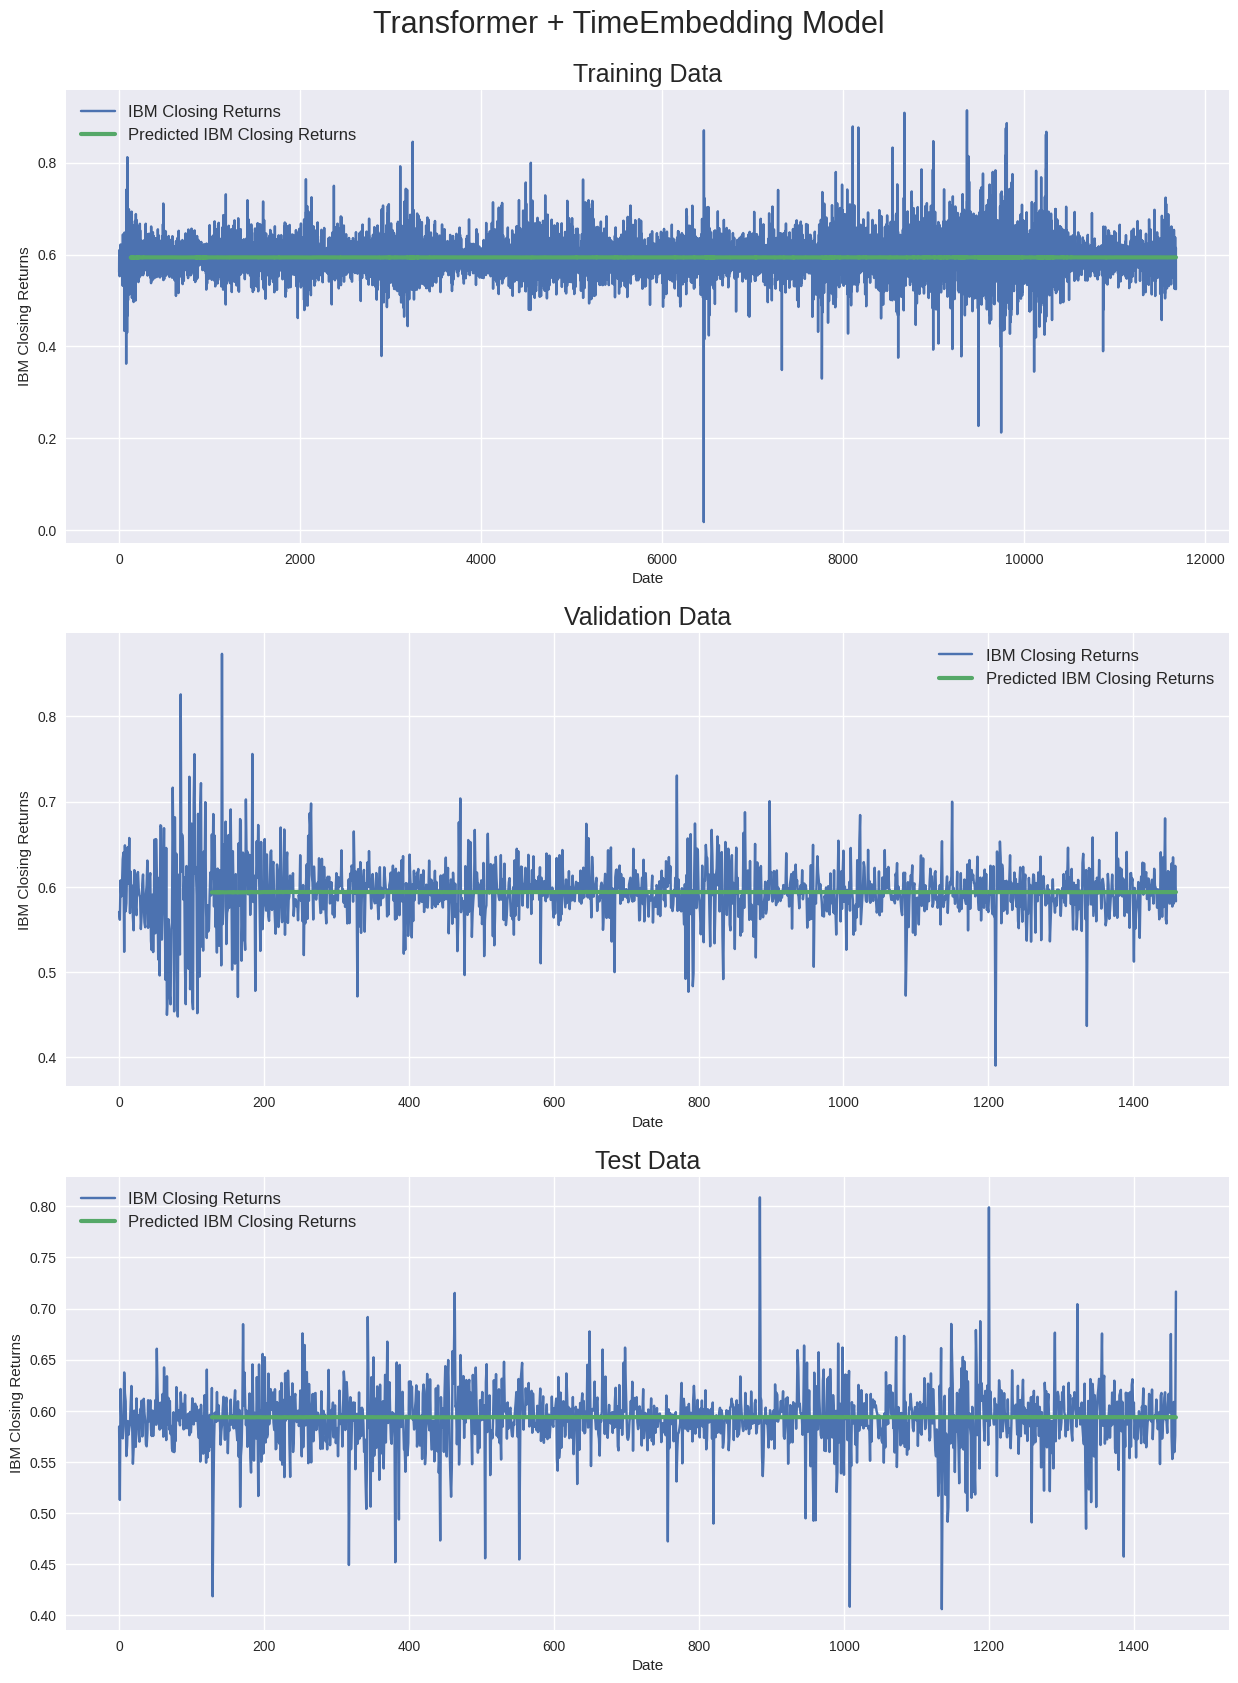

In [13]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.keras',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model('Transformer+TimeEmbedding.keras',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

361/361 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
 
Evaluation metrics
Training Data - Loss: 0.0015, MAE: 0.0276, MAPE: 4.9864
Validation Data - Loss: 0.0010, MAE: 0.0224, MAPE: 3.8027
Test Data - Loss: 0.0010, MAE: 0.0219, MAPE: 3.7875


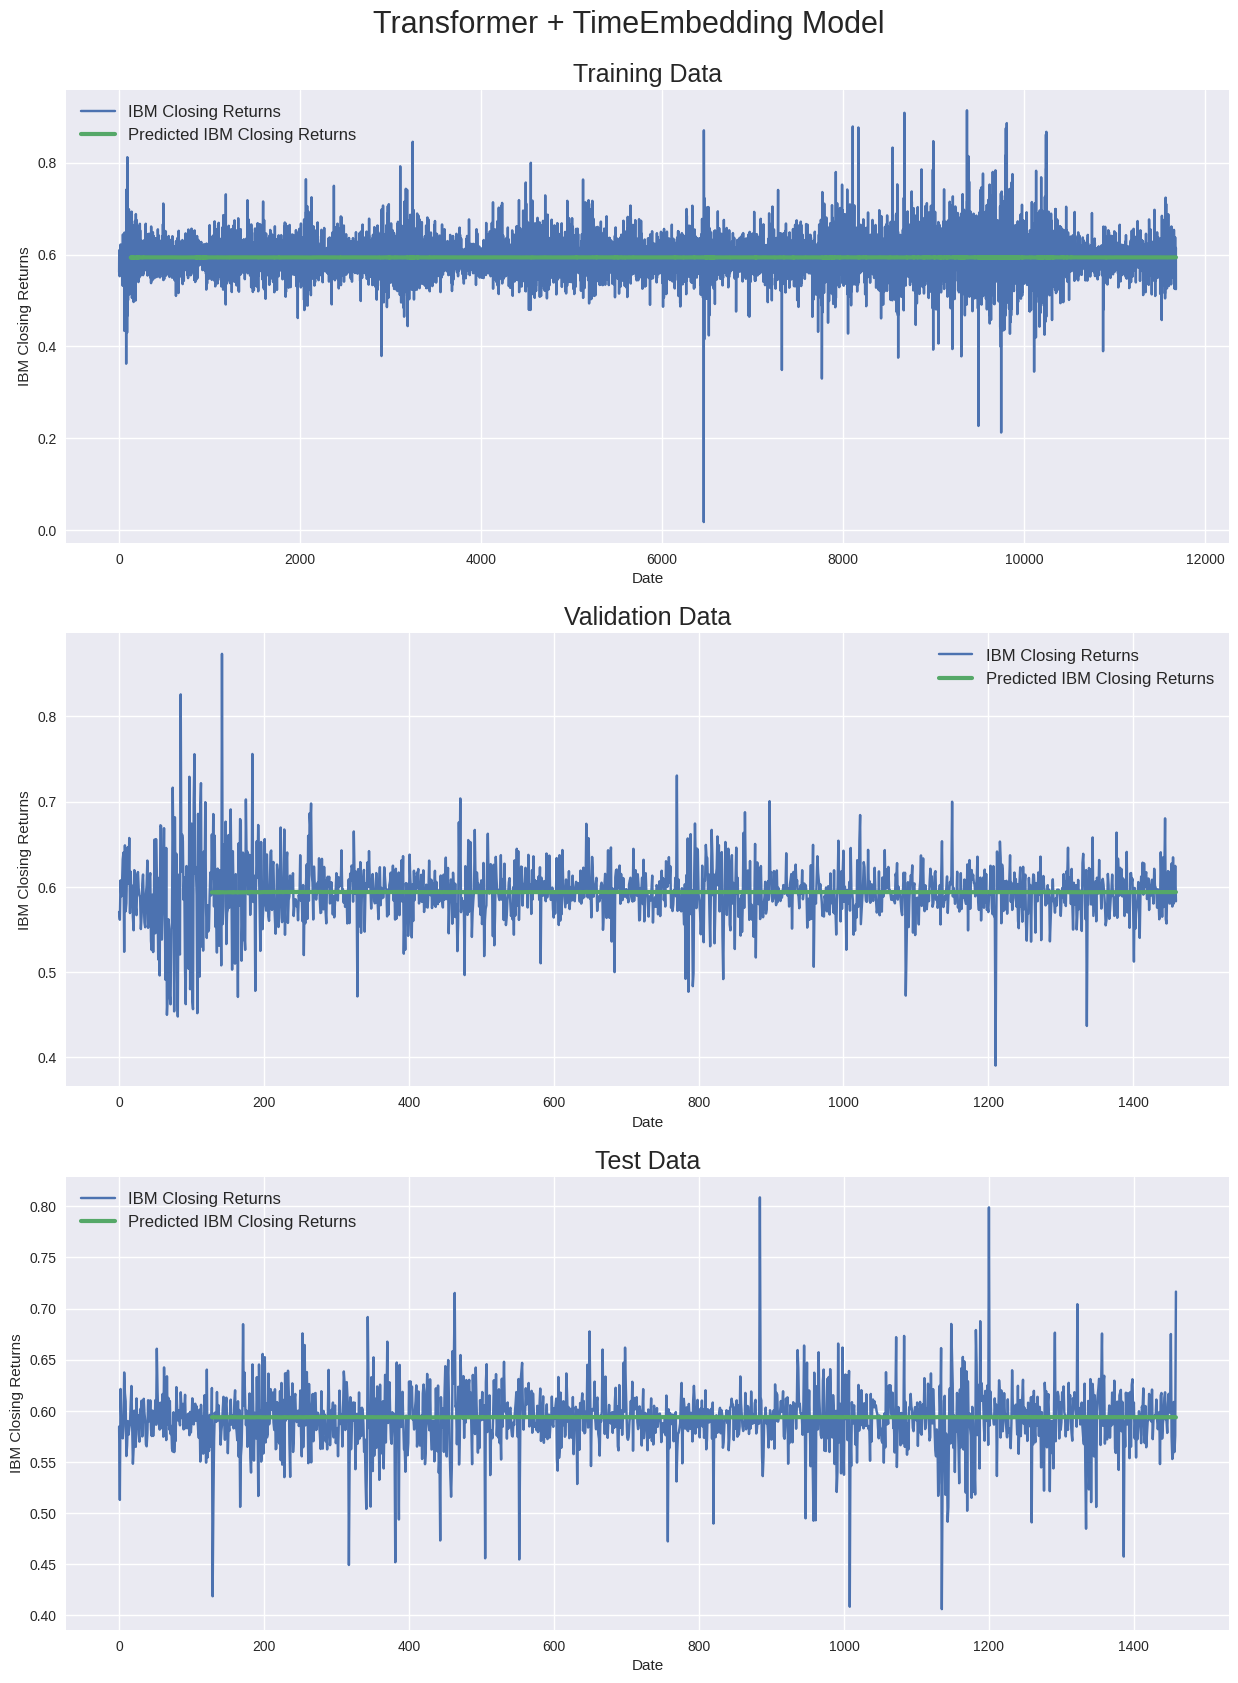

In [14]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

Model metrics

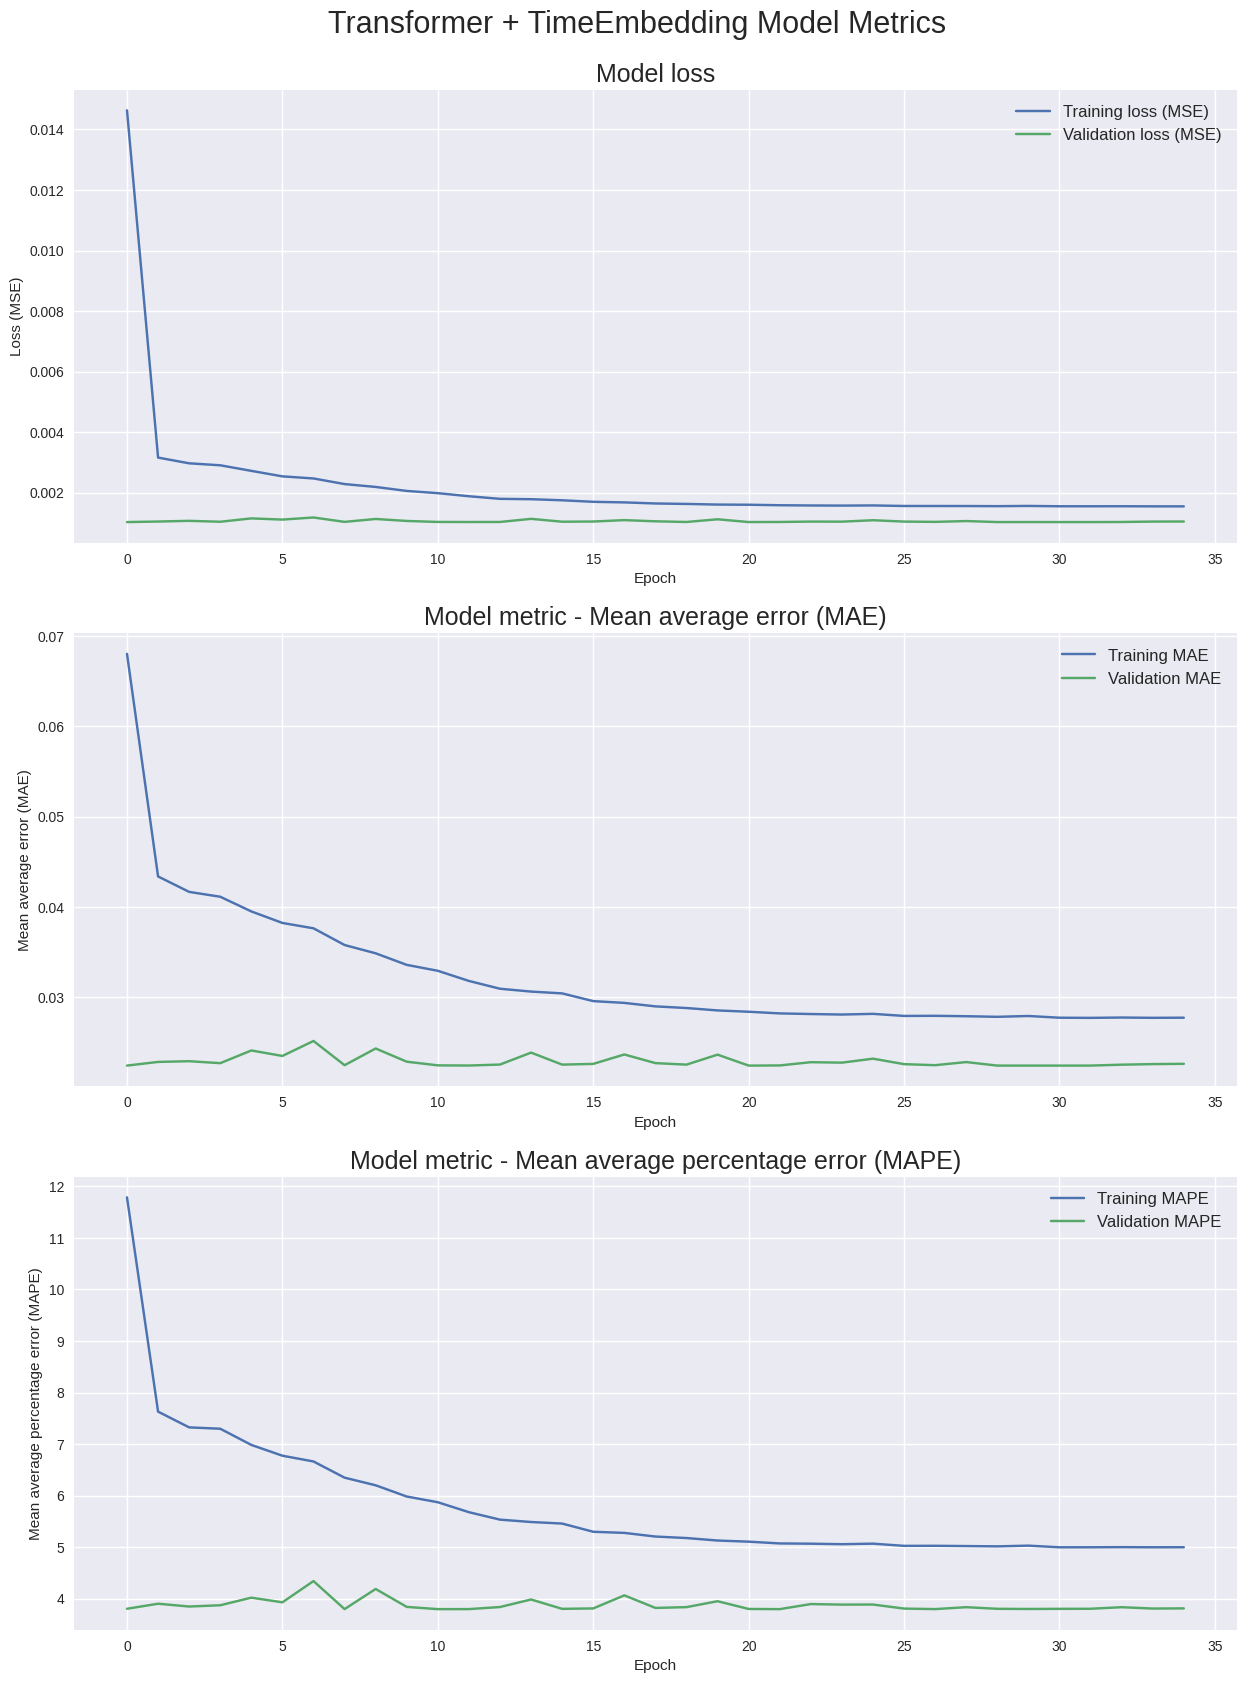

In [15]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

Model architecture overview

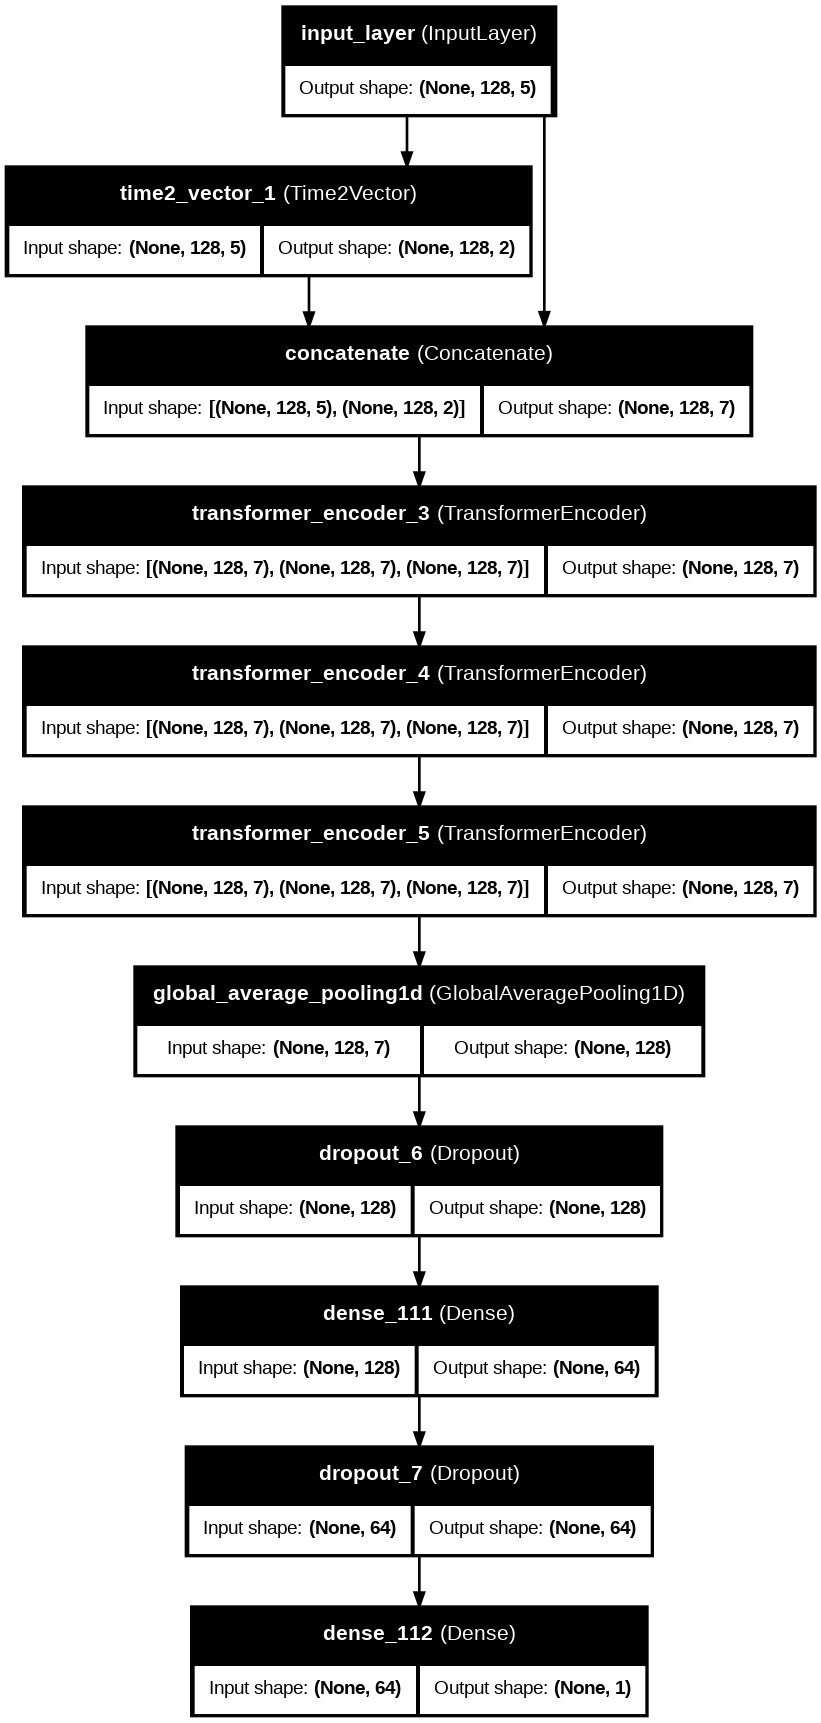

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)

## Moving Average
### Moving Average - Load IBM data again, to apply rolling window

In [17]:
IBM_path = 'IBM.csv'

df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
9,1962-02-15,7.047164,7.074570,7.007648,7.034417,291834.0
10,1962-02-16,7.035054,7.060548,6.998088,7.017208,262023.0
11,1962-02-19,7.017846,7.046527,6.985341,7.001912,258885.0
12,1962-02-20,7.002868,7.033779,6.972913,6.986297,262023.0
13,1962-02-21,6.986616,7.018483,6.951562,6.964946,273790.5


Moving Average - Plot daily IBM closing prices and volume

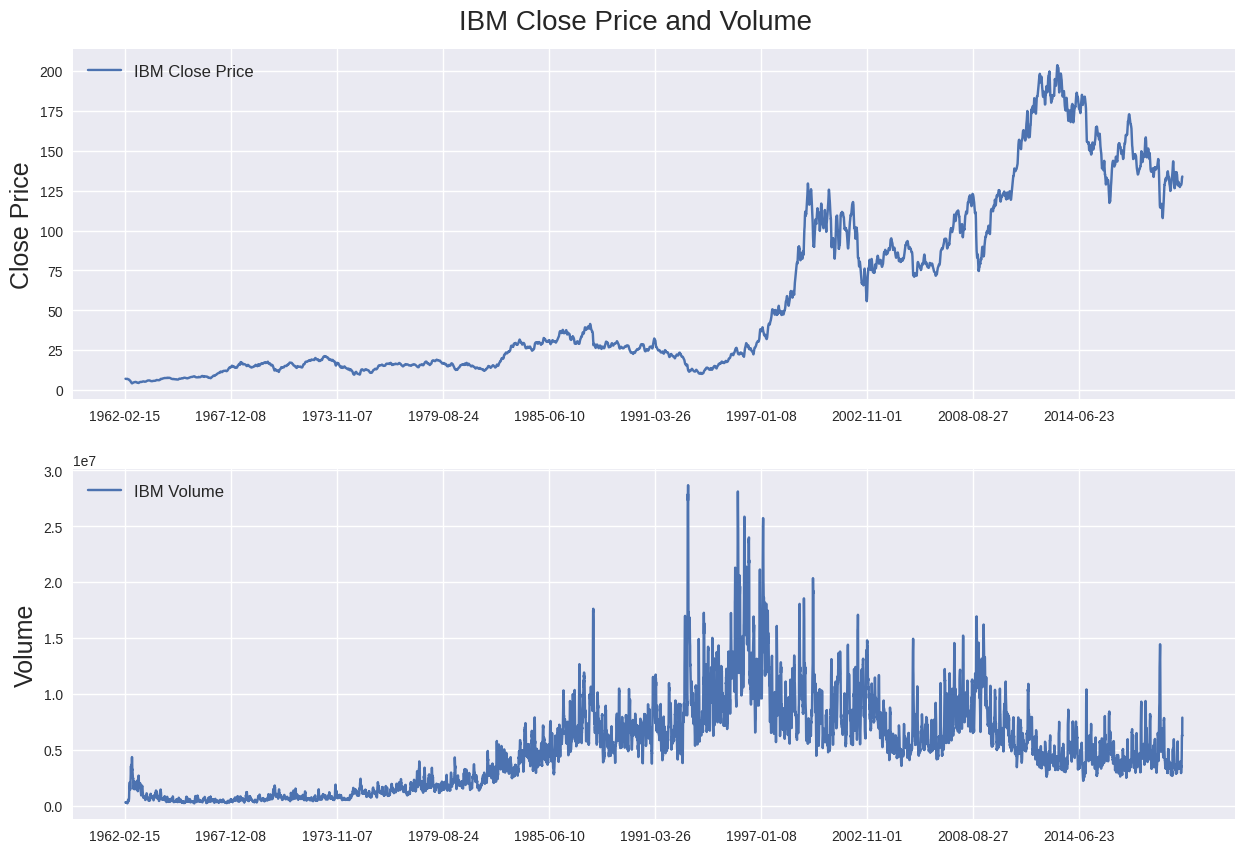

In [18]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='IBM Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='IBM Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

Moving Average - Calculate normalized percentage change for all columns

In [19]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11671, 5)
Validation data shape: (1459, 5)
Test data shape: (1458, 5)


,Open,High,Low,Close,Volume
10,0.523780,0.519905,0.528985,0.513080,0.274646
11,0.513083,0.519847,0.522264,0.516997,0.350737
12,0.517667,0.522448,0.522886,0.516258,0.371071
13,0.514924,0.517072,0.504029,0.504115,0.398739
14,0.506129,0.503654,0.505912,0.507341,0.447885


Moving Average - Plot daily changes of close price and volume

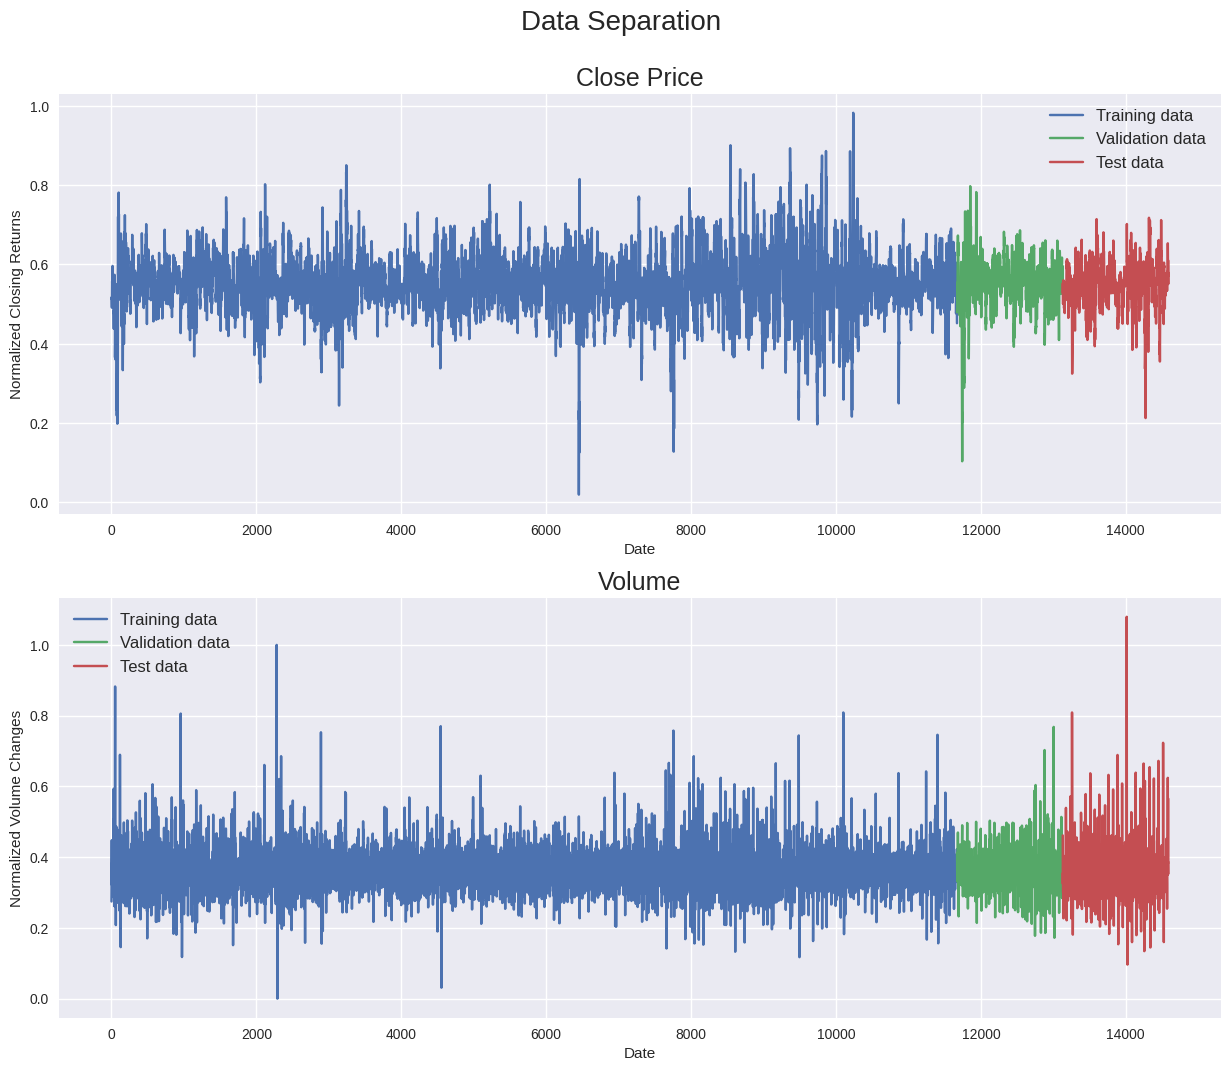

In [20]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

Moving Average - Create chunks of training, validation, and test data

In [21]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11543, 128, 5) (11543,)
(1331, 128, 5) (1331,)


Moving Average - Model

In [22]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding2.keras',
                                              monitor='val_loss',
                                              save_best_only=True,
                                              verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model('Transformer+TimeEmbedding2.keras',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 5)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector_2            │ (None, 128, 2)         │            512 │ input_layer_1[0][0]    │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 7)         │              0 │ input_layer_1[0][0],   │
│ (Concatenate)             │                        │                │ time2_vector_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_6     │ (None, 128, 7)         │         99,114 │ concatenate_1[0][0],   │
│ (TransformerEncoder)      │                        │                │ concatenate_1[0][0],   │
│                           │                        │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_7     │ (None, 128, 7)         │         99,114 │ transformer_encoder_6… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder_6… │
│                           │                        │                │ transformer_encoder_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_8     │ (None, 128, 7)         │         99,114 │ transformer_encoder_7… │
│ (TransformerEncoder)      │                        │                │ transformer_encoder_7… │
│                           │                        │                │ transformer_encoder_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ transformer_encoder_8… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 128)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_335 (Dense)         │ (None, 64)             │          8,256 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 64)             │              0 │ dense_335[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_336 (Dense)         │ (None, 1)              │             65 │ dropout_21[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 306,175 (1.17 MB)

 Trainable params: 306,175 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.0474 - mae: 0.1416 - mape: 26.1027
Epoch 1: val_loss improved from inf to 0.00326, saving model to Transformer+TimeEmbedding2.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 134s 188ms/step - loss: 0.0473 - mae: 0.1415 - mape: 26.0741 - val_loss: 0.0033 - val_mae: 0.0442 - val_mape: 7.7910
Epoch 2/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0066 - mae: 0.0622 - mape: 12.6386
Epoch 2: val_loss improved from 0.00326 to 0.00321, saving model to Transformer+TimeEmbedding2.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 84s 95ms/step - loss: 0.0066 - mae: 0.0622 - mape: 12.6367 - val_loss: 0.0032 - val_mae: 0.0440 - val_mape: 8.2568
Epoch 3/35
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0067 - mae: 0.0619 - mape: 12.0241
Epoch 3: val_loss did not improve from 0.00321
361/361 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - loss: 0.0067 - mae: 0.0619 - mape: 12.0238 - val_loss: 0.0033 - val_mae: 0.0446 - val_mape: 7.8511
Epoch 4/35
361/361 ━━━━━━━

361/361 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
 
Evaluation metrics
Training Data - Loss: 0.0008, MAE: 0.0210, MAPE: 4.1436
Validation Data - Loss: 0.0006, MAE: 0.0175, MAPE: 3.1800
Test Data - Loss: 0.0007, MAE: 0.0184, MAPE: 3.5843


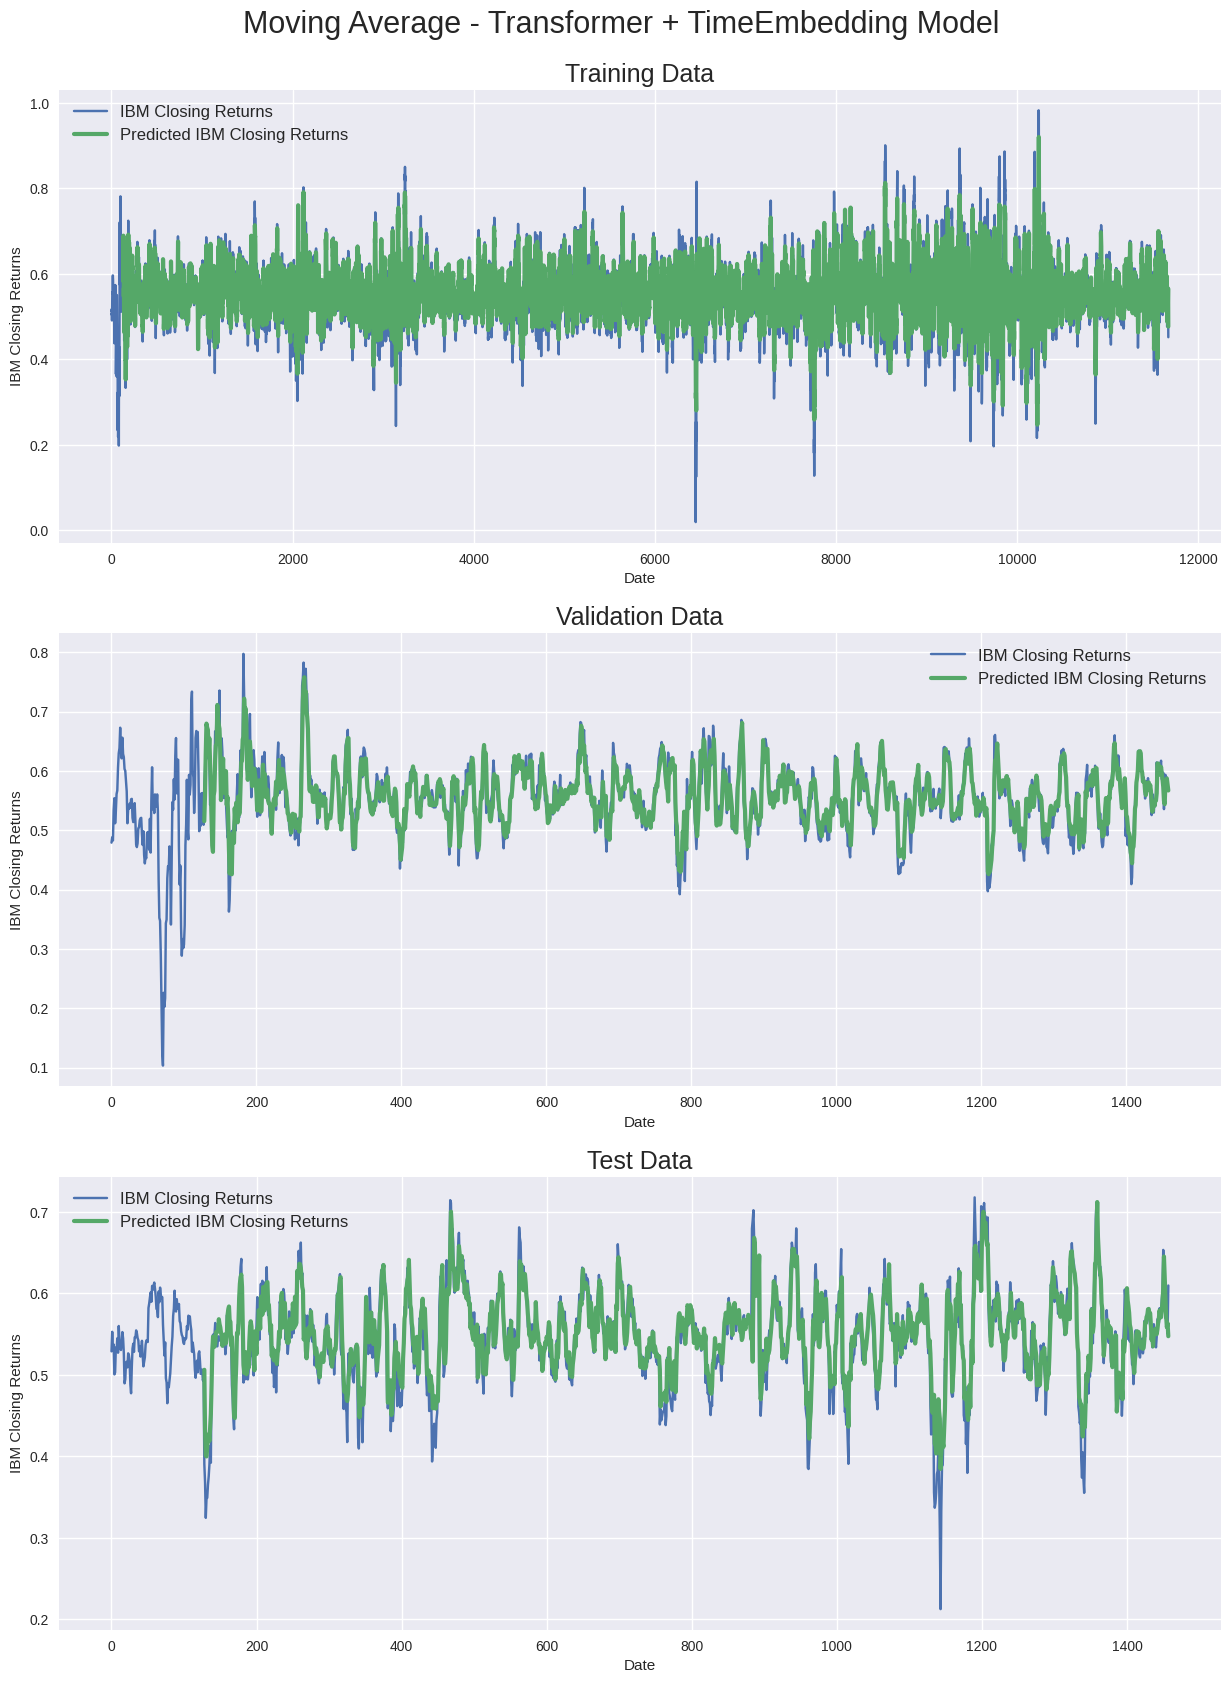

In [23]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

Moving Average - Model metrics

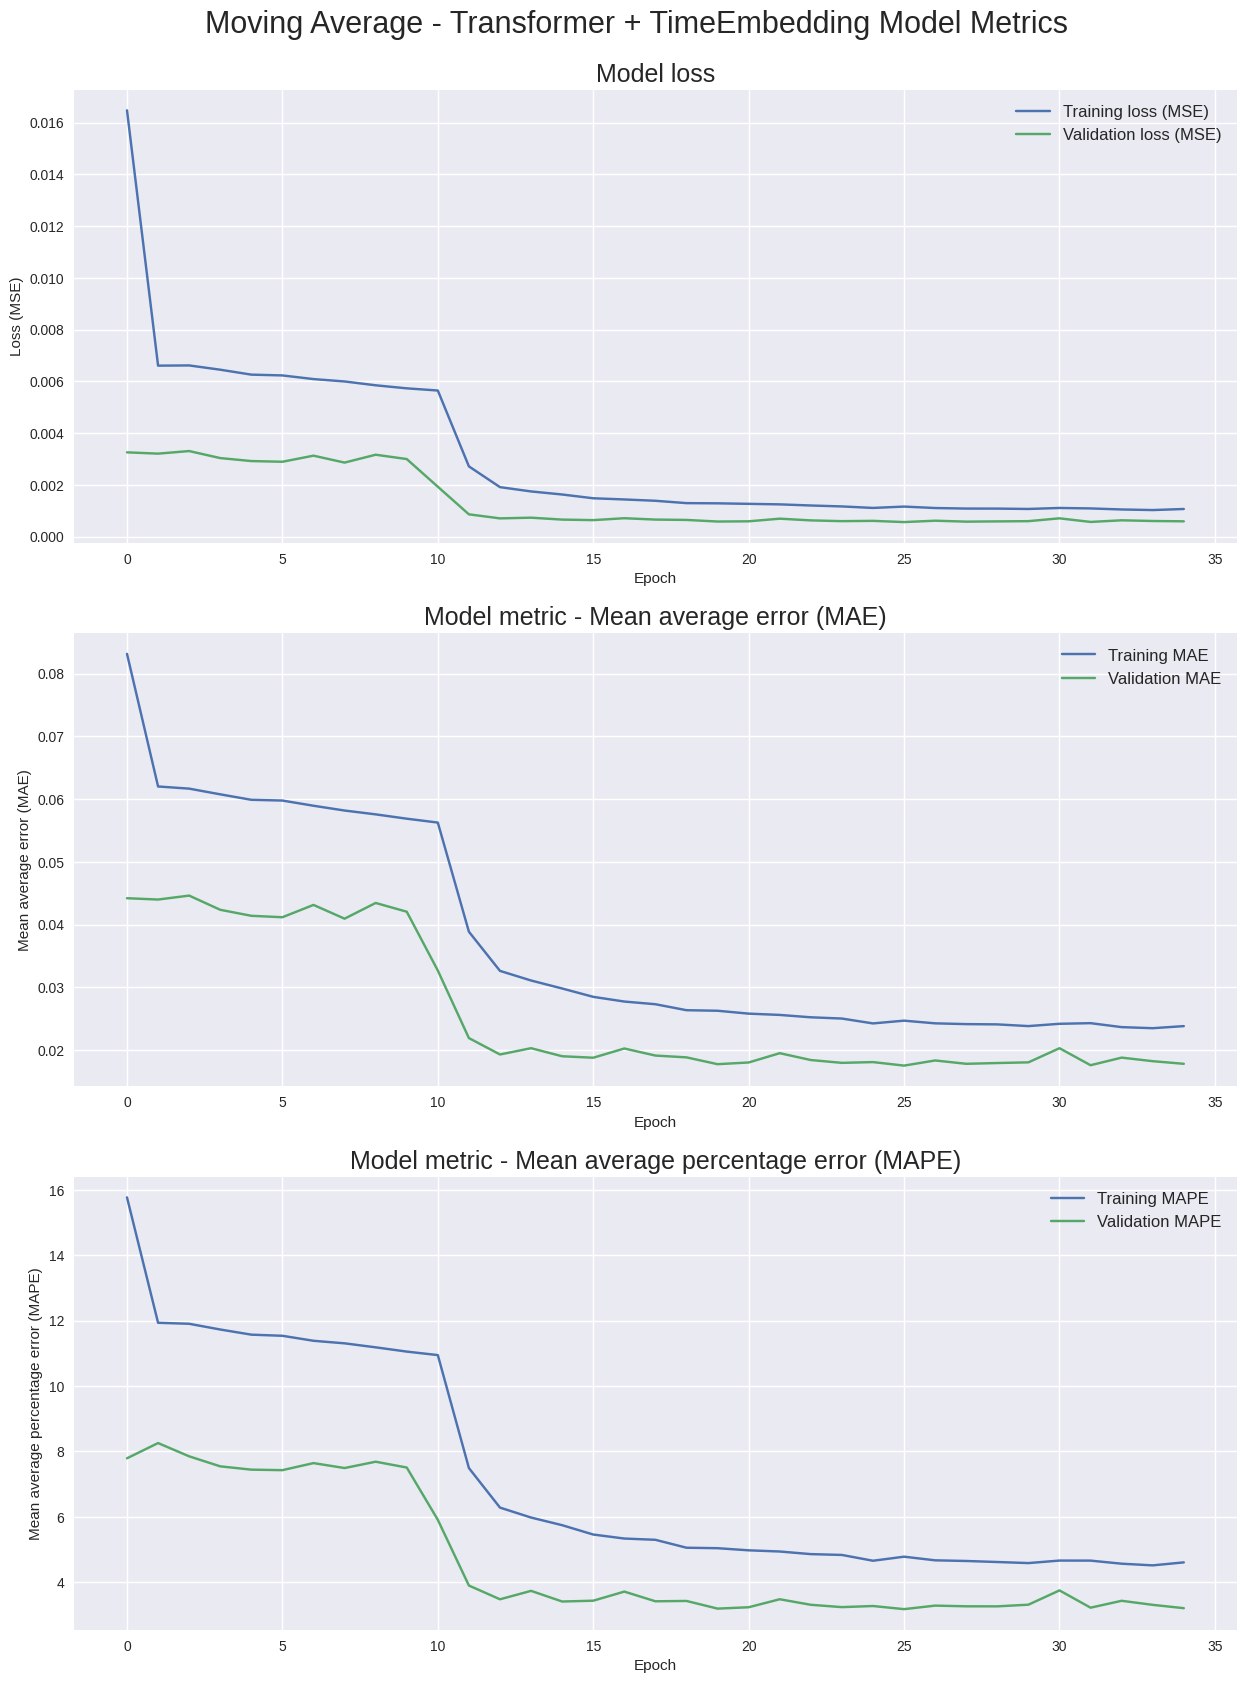

In [24]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)